In [1]:
from __future__ import division, print_function, unicode_literals
from datetime import datetime
import numpy as np
import os
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

from sklearn import metrics
from sklearn.metrics import pairwise_distances

from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

np.random.seed(42)

/usr/local/lib/python2.7/dist-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/usr/local/lib/python2.7/dist-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/usr/local/lib/python2.7/dist-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/usr/local/lib/python2.7/dist-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/usr/local/lib/python2.7/dist-packages/pandas/core/indexes/base.py:7: RuntimeWarning: numpy.dtype size changed, may indicate bi

Analysis Workflow Overview


1. Read in complete feature files
Feature Selection (Explicit, knowledge driven for now)
2. Define columns sets for inclusion / exclusion in cluster analysis
- EXCLUDE columns set identifying columns to be dropped from further analysis.  These are columns that have been one hot encoded and/or contain summarized values and indicators that are not atthe record level and ot useful for the analysis
- KPI_INDEX columns: columns containing key revenue performance measures including derived measures
- METADATA columns:  columns that will not be used in pattern detection but will be used for explanation of patterns
Feature Prep
3. Scale the desired KPIs so all columns used in the cluster analysis are of similar magnitude (usually 0-1)
4. Create dataset with KPI and METADATA columns excluded.  To be used in cluster analysis
- Optionally merge scaled KPIs for inclusion in clustering . (When included, the patterns may localize on both feature vectors and outcome variables i.e. outcome auto analysis)
Clustering
5. Define and fit cluster model
   - Evaluate cluster quality metrics and iterate on clustering parameters (nclusters etc).  This step needs to be automated in the future
6. Generate cluster output file with KPI and METADATA columns reappended along with cluster labels
Visualization
7. PCA visualization
8. TSNE visualization
   - optionally include/exclude the cluster label in generating TSNE dimensional reduction for visualization
9. Generate final output file after appending 2D TSNE dimensions for use in external BI viz tools
Explanation
10. For each cluster, train a DRF on two classes: in cluster, out of cluster.  
   - output the Importance variables for each cluster to be used in external BI/ end user app

### 1. Read in Feature File 

In [2]:
# 1. Read the features file
feature_data = pd.read_csv('Demo_CMS_IP_features_columns.csv')

In [3]:
feature_data.dtypes
feature_data.head(3)

DESYNPUF_ID                        object
CLM_ID                              int64
SEGMENT                             int64
CLM_FROM_DT                        object
CLM_THRU_DT                        object
PRVDR_NUM                          object
CLM_PMT_AMT                       float64
NCH_PRMRY_PYR_CLM_PD_AMT          float64
AT_PHYSN_NPI                      float64
OP_PHYSN_NPI                      float64
OT_PHYSN_NPI                      float64
CLM_ADMSN_DT                       object
ADMTNG_ICD9_DGNS_CD                object
CLM_PASS_THRU_PER_DIEM_AMT        float64
NCH_BENE_IP_DDCTBL_AMT            float64
NCH_BENE_PTA_COINSRNC_LBLTY_AM    float64
NCH_BENE_BLOOD_DDCTBL_LBLTY_AM    float64
CLM_UTLZTN_DAY_CNT                  int64
NCH_BENE_DSCHRG_DT                  int64
CLM_DRG_CD                         object
ICD9_DGNS_CD_1                     object
ICD9_DGNS_CD_2                     object
ICD9_DGNS_CD_3                     object
ICD9_DGNS_CD_4                    

,DESYNPUF_ID,CLM_ID,SEGMENT,CLM_FROM_DT,CLM_THRU_DT,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,OP_PHYSN_NPI,...,MEDREIMB_IP,BENRES_IP,PPPYMT_IP,MEDREIMB_OP,BENRES_OP,PPPYMT_OP,MEDREIMB_CAR,BENRES_CAR,PPPYMT_CAR,BENE_Age_Group
0,00013D2EFD8E45D1,196661176988405,1,2010-03-12,2010-03-13,2600GD,4000.0,0.0,3.139084e+09,NaN,...,0.0,0.0,0.0,50.0,10.0,0.0,0.0,0.0,0.0,4.0
1,00016F745862898F,196201177000368,1,2009-04-12,2009-04-18,3900MB,26000.0,0.0,6.476809e+09,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,700.0,240.0,0.0,3.0
2,00016F745862898F,196661177015632,1,2009-08-31,2009-09-02,3900HM,5000.0,0.0,6.119985e+08,611998537.0,...,0.0,0.0,0.0,0.0,0.0,0.0,700.0,240.0,0.0,3.0


### 2. Define columns sets for inclusion / exclusion in cluster analysis
- EXCLUDE columns set identifying columns to be dropped from further analysis.  These are columns that have been one hot encoded and/or contain summarized values and indicators that are not atthe record level and ot useful for the analysis
- KPI_INDEX columns: columns containing key revenue performance measures including derived measures
- METADATA columns:  columns that will not be used in pattern detection but will be used for explanation of patterns

In [4]:
#Exclude these columns from all analysis as they have already been one hot encoded or are summarry columns from beneficiary file.
EXCLUDE_COLUMNS = ['DESYNPUF_ID','CLM_ID','SEGMENT', 'CLM_FROM_DT', 'CLM_THRU_DT',
                  'CLM_ADMSN_DT', 'ADMTNG_ICD9_DGNS_CD', 'NCH_BENE_DSCHRG_DT', 'CLM_DRG_CD', 'ICD9_DGNS_CD_1', 'ICD9_DGNS_CD_2',
                  'ICD9_DGNS_CD_3', 'ICD9_DGNS_CD_4', 'ICD9_DGNS_CD_5', 'ICD9_DGNS_CD_6', 'ICD9_DGNS_CD_7', 'ICD9_DGNS_CD_8', 'ICD9_DGNS_CD_9', 'ICD9_DGNS_CD_10',
                  'ICD9_PRCDR_CD_1','ICD9_PRCDR_CD_2', 'ICD9_PRCDR_CD_3', 'ICD9_PRCDR_CD_4', 'ICD9_PRCDR_CD_5', 'ICD9_PRCDR_CD_6',
                  'BENE_ESRD_IND', 'BENE_BIRTH_DT', 'BENE_DEATH_DT', 'SP_ALZHDMTA', 'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD', 'SP_DEPRESSN', 'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA',
                  'MEDREIMB_IP','BENRES_IP','PPPYMT_IP', 'MEDREIMB_OP', 'BENRES_OP', 'PPPYMT_OP', 'MEDREIMB_CAR', 'PPPYMT_CAR', 'BENRES_CAR']

#Define Key Performance Indicator columns.  These are the key revenue performance measures that need to be optimized
KPI_INDEX_COLUMNS = ['CLM_PMT_AMT', 'NCH_PRMRY_PYR_CLM_PD_AMT', 'CLM_UTLZTN_DAY_CNT', 'LOG_CLM_PMT_AMT', 'LOG_NCH_PRMRY_PYR_CLM_PD_AMT']


#Metdata columns that are NOT use in pattern detection but used to EXPLAIN the patterns and provide root cause analysis
METADATA_COLUMNS = ['PRVDR_NUM', 'AT_PHYSN_NPI','OP_PHYSN_NPI', 'OT_PHYSN_NPI','SP_STATE_CODE','BENE_COUNTY_CD','BENE_SEX_IDENT_CD','BENE_RACE_CD',
                   'BENE_HI_CVRAGE_TOT_MONS', 'BENE_SMI_CVRAGE_TOT_MONS', 'BENE_HMO_CVRAGE_TOT_MONS', 'PLAN_CVRG_MOS_NUM', 'CLM_FROM_Year', 'CLM_FROM_Month', 'CLM_FROM_Day', 'CLM_FROM_DOW',
                   'CLM_PASS_THRU_PER_DIEM_AMT', 'NCH_BENE_IP_DDCTBL_AMT','NCH_BENE_BLOOD_DDCTBL_LBLTY_AM', 'NCH_BENE_PTA_COINSRNC_LBLTY_AM', 'LOG_CLM_PASS_THRU_PER_DIEM_AMT', 
                   'LOG_NCH_BENE_IP_DDCTBL_AMT', 'LOG_NCH_BENE_PTA_COINSRNC_LBLTY_AM', 'LOG_NCH_BENE_BLOOD_DDCTBL_LBLTY_AM']


In [5]:
feature_data.describe(include='all')
#data['ICD9_DGNS_CD_1'].head(10)
#data['ICD9_PRCDR_CD_1'].head(10)


,DESYNPUF_ID,CLM_ID,SEGMENT,CLM_FROM_DT,CLM_THRU_DT,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,OP_PHYSN_NPI,...,MEDREIMB_IP,BENRES_IP,PPPYMT_IP,MEDREIMB_OP,BENRES_OP,PPPYMT_OP,MEDREIMB_CAR,BENRES_CAR,PPPYMT_CAR,BENE_Age_Group
count,9984,9.984000e+03,9984.0,9984,9984,9984,9984.000000,9984.000000,9.908000e+03,5.828000e+03,...,9984.000000,9984.000000,9984.000000,9984.000000,9984.000000,9984.000000,9984.000000,9984.000000,9984.000000,9984.000000
unique,5622,NaN,NaN,1099,1088,1842,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,019E4729585EF3DD,NaN,NaN,2008-07-24,2008-06-02,23006G,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,11,NaN,NaN,23,25,125,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.965023e+14,1.0,NaN,NaN,NaN,9501.324119,438.010817,5.019069e+09,5.149653e+09,...,12706.753806,1374.964543,714.122596,1548.319311,486.218950,77.973758,2827.805489,766.728766,44.731571,3.664163
std,NaN,2.861480e+11,0.0,NaN,NaN,NaN,9211.635289,3694.872532,2.916123e+09,2.933019e+09,...,19231.105364,1945.329665,5065.451295,3106.412887,871.856803,655.375977,2469.790398,634.587810,150.686193,0.732124
min,NaN,1.960112e+14,1.0,NaN,NaN,NaN,-3000.000000,0.000000,3.320659e+06,1.159725e+06,...,-3000.000000,0.000000,0.000000,-40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,NaN,1.962512e+14,1.0,NaN,NaN,NaN,4000.000000,0.000000,2.478422e+09,2.588811e+09,...,0.000000,0.000000,0.000000,90.000000,20.000000,0.000000,1050.000000,300.000000,0.000000,3.000000
50%,NaN,1.965012e+14,1.0,NaN,NaN,NaN,7000.000000,0.000000,4.965742e+09,5.150433e+09,...,5000.000000,1024.000000,0.000000,560.000000,180.000000,0.000000,2260.000000,620.000000,0.000000,4.000000
75%,NaN,1.967512e+14,1.0,NaN,NaN,NaN,11000.000000,0.000000,7.584837e+09,7.751198e+09,...,18000.000000,2048.000000,0.000000,1720.000000,570.000000,0.000000,3950.000000,1080.000000,20.000000,4.000000


# Feature Prep 

### 3. Scale the desired KPIs so all columns used in the cluster analysis are of similar magnitude (usually 0-1)

In [7]:
# Scale KPIs

KPI_COLUMNS = ['CLM_PMT_AMT']    
SCALED_KPI_COLUMNS = ['SCALED_CLM_PMT_AMT']
#scaler = RobustScaler(quantile_range=(25, 75))
scaler = MinMaxScaler()
scaled_kpi_data = pd.DataFrame(scaler.fit_transform(feature_data[KPI_COLUMNS]), columns=SCALED_KPI_COLUMNS)
scaled_kpi_data.head(10)

,SCALED_CLM_PMT_AMT
0,0.116667
1,0.483333
2,0.133333
3,0.133333
4,0.316667
5,0.283333
6,0.133333
7,0.133333
8,0.283333
9,0.533333


### Create "Orig Cluster Data" with all original KPIs but exclude columns dropped
- Optionally create Scaled cluster dataset wth merged scaled KPIs for inclusion in clustering . (When included, the patterns may localize on both feature vectors and outcome variables i.e. outcome auto analysis)

In [8]:
orig_cluster_data = feature_data.drop(EXCLUDE_COLUMNS, axis=1)

In [9]:
# Option 1 (comment out option 2)
#scaled_cluster_data = orig_cluster_data.copy()

# Option 2 Create "scaled cluster Data" with scaled KPIs ("Outcome auto analyis")
a = orig_cluster_data.copy()
b = scaled_kpi_data.copy()
a.reset_index(drop=True, inplace=True)
b.reset_index(drop=True, inplace=True)
scaled_cluster_data = pd.concat([a,b], axis=1)
scaled_cluster_data.head(3)
scaled_cluster_data.dtypes

,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,OP_PHYSN_NPI,OT_PHYSN_NPI,CLM_PASS_THRU_PER_DIEM_AMT,NCH_BENE_IP_DDCTBL_AMT,NCH_BENE_PTA_COINSRNC_LBLTY_AM,NCH_BENE_BLOOD_DDCTBL_LBLTY_AM,...,BENE_SEX_IDENT_CD,BENE_RACE_CD,SP_STATE_CODE,BENE_COUNTY_CD,BENE_HI_CVRAGE_TOT_MONS,BENE_SMI_CVRAGE_TOT_MONS,BENE_HMO_CVRAGE_TOT_MONS,PLAN_CVRG_MOS_NUM,BENE_Age_Group,SCALED_CLM_PMT_AMT
0,2600GD,4000.0,0.0,3.139084e+09,NaN,NaN,0.0,1100.0,0.0,0.0,...,1,1,26,950,12,12,12,12,4.0,0.116667
1,3900MB,26000.0,0.0,6.476809e+09,NaN,NaN,0.0,1068.0,0.0,0.0,...,1,1,39,230,12,12,0,0,3.0,0.483333
2,3900HM,5000.0,0.0,6.119985e+08,611998537.0,NaN,0.0,1068.0,0.0,0.0,...,1,1,39,230,12,12,0,0,3.0,0.133333


PRVDR_NUM                              object
CLM_PMT_AMT                           float64
NCH_PRMRY_PYR_CLM_PD_AMT              float64
AT_PHYSN_NPI                          float64
OP_PHYSN_NPI                          float64
OT_PHYSN_NPI                          float64
CLM_PASS_THRU_PER_DIEM_AMT            float64
NCH_BENE_IP_DDCTBL_AMT                float64
NCH_BENE_PTA_COINSRNC_LBLTY_AM        float64
NCH_BENE_BLOOD_DDCTBL_LBLTY_AM        float64
CLM_UTLZTN_DAY_CNT                      int64
proc_9904                               int64
proc_8154                               int64
proc_3893                               int64
proc_66                                 int64
proc_3995                               int64
proc_4516                               int64
proc_3722                               int64
proc_9671                               int64
proc_8872                               int64
proc_8151                               int64
proc_4513                         

# cms_ip Cluster

## Optionally Reset Kernel to free up memory

In [13]:
#Repetition in case kernel reset
#Exclude these columns from all analysis as they have already been one hot encoded or are summarry columns from beneficiary file.
EXCLUDE_COLUMNS = ['DESYNPUF_ID','CLM_ID','SEGMENT', 'CLM_FROM_DT', 'CLM_THRU_DT',
                  'CLM_ADMSN_DT', 'ADMTNG_ICD9_DGNS_CD', 'NCH_BENE_DSCHRG_DT', 'CLM_DRG_CD', 'ICD9_DGNS_CD_1', 'ICD9_DGNS_CD_2',
                  'ICD9_DGNS_CD_3', 'ICD9_DGNS_CD_4', 'ICD9_DGNS_CD_5', 'ICD9_DGNS_CD_6', 'ICD9_DGNS_CD_7', 'ICD9_DGNS_CD_8', 'ICD9_DGNS_CD_9', 'ICD9_DGNS_CD_10',
                  'ICD9_PRCDR_CD_1','ICD9_PRCDR_CD_2', 'ICD9_PRCDR_CD_3', 'ICD9_PRCDR_CD_4', 'ICD9_PRCDR_CD_5', 'ICD9_PRCDR_CD_6',
                  'BENE_ESRD_IND', 'BENE_BIRTH_DT', 'BENE_DEATH_DT', 'SP_ALZHDMTA', 'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD', 'SP_DEPRESSN', 'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA',
                  'MEDREIMB_IP','BENRES_IP','PPPYMT_IP', 'MEDREIMB_OP', 'BENRES_OP', 'PPPYMT_OP', 'MEDREIMB_CAR', 'PPPYMT_CAR', 'BENRES_CAR']

#Define Key Performance Indicator columns.  These are the key revenue performance measures that need to be optimized
KPI_INDEX_COLUMNS = ['CLM_PMT_AMT', 'NCH_PRMRY_PYR_CLM_PD_AMT', 'CLM_UTLZTN_DAY_CNT', 'LOG_CLM_PMT_AMT', 'LOG_NCH_PRMRY_PYR_CLM_PD_AMT']


#Metdata columns that are NOT use in pattern detection but used to EXPLAIN the patterns and provide root cause analysis
METADATA_COLUMNS = ['PRVDR_NUM', 'AT_PHYSN_NPI','OP_PHYSN_NPI', 'OT_PHYSN_NPI','SP_STATE_CODE','BENE_COUNTY_CD','BENE_SEX_IDENT_CD','BENE_RACE_CD',
                   'BENE_HI_CVRAGE_TOT_MONS', 'BENE_SMI_CVRAGE_TOT_MONS', 'BENE_HMO_CVRAGE_TOT_MONS', 'PLAN_CVRG_MOS_NUM', 'CLM_FROM_Year', 'CLM_FROM_Month', 'CLM_FROM_Day', 'CLM_FROM_DOW',
                   'CLM_PASS_THRU_PER_DIEM_AMT', 'NCH_BENE_IP_DDCTBL_AMT','NCH_BENE_BLOOD_DDCTBL_LBLTY_AM', 'NCH_BENE_PTA_COINSRNC_LBLTY_AM', 'LOG_CLM_PASS_THRU_PER_DIEM_AMT', 
                   'LOG_NCH_BENE_IP_DDCTBL_AMT', 'LOG_NCH_BENE_PTA_COINSRNC_LBLTY_AM', 'LOG_NCH_BENE_BLOOD_DDCTBL_LBLTY_AM']


### 4. Create dataset with KPI and METADATA columns excluded.  To be used in cluster analysis.
- Optionally this includes previously merged scaled KPIs for inclusion in clustering . (When included, the patterns may localize on both feature vectors and outcome variables i.e. outcome auto analysis)

In [14]:
#copy the full scaled cluster feature set data 
cms_ip_cluster_output = scaled_cluster_data.copy()
ready_cluster_data_cms_ip = scaled_cluster_data.drop(KPI_INDEX_COLUMNS, axis=1)
ready_cluster_data_cms_ip = ready_cluster_data_cms_ip.drop(METADATA_COLUMNS, axis=1)
X_cms_ip = ready_cluster_data_cms_ip.values
X_cms_ip[0:3,:]
X_cms_ip.shape
ready_cluster_data_cms_ip.dtypes
ready_cluster_data_cms_ip.head(3)

array([[0.        , 0.        , 0.        , ..., 1.        , 4.        ,
        0.11666667],
       [0.        , 0.        , 0.        , ..., 1.        , 3.        ,
        0.48333333],
       [0.        , 0.        , 0.        , ..., 1.        , 3.        ,
        0.13333333]])

(9984, 473)

proc_9904               int64
proc_8154               int64
proc_3893               int64
proc_66                 int64
proc_3995               int64
proc_4516               int64
proc_3722               int64
proc_9671               int64
proc_8872               int64
proc_8151               int64
proc_4513               int64
proc_9390               int64
proc_9672               int64
proc_7935               int64
proc_5123               int64
proc_8152               int64
proc_3491               int64
proc_9339               int64
proc_3812               int64
proc_3950               int64
proc_3772               int64
proc_8622               int64
proc_4523               int64
proc_309                int64
proc_387                int64
proc_8108               int64
proc_9921               int64
proc_4525               int64
proc_5491               int64
proc_4311               int64
                       ...   
dx_5602                 int64
dx_4871                 int64
dx_3962   

,proc_9904,proc_8154,proc_3893,proc_66,proc_3995,proc_4516,proc_3722,proc_9671,proc_8872,proc_8151,...,dx_4168,dx_1972,dx_56969,dx_43889,dx_42841,dx_4439,dx_3843,dx_OTHER_DX,BENE_Age_Group,SCALED_CLM_PMT_AMT
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,4.0,0.116667
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,3.0,0.483333
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,3.0,0.133333


# Clustering 

### 5. Define and fit cluster model
   - Evaluate cluster quality metrics and iterate on clustering parameters (nclusters etc).  This step needs to be automated in the future
### 6. Generate cluster output file with KPI and METADATA columns reappended along with cluster labels

In [ ]:
def cluster_model(n_cluster):
#    model = AgglomerativeClustering(n_clusters=n_cluster,linkage="complete", affinity="cosine")
#    model = AgglomerativeClustering(n_clusters=n_cluster,linkage="complete", affinity="manhattan")
    model = KMeans(n_clusters=n_cluster, random_state=0)
    return model

In [15]:
n_cms_ip_cluster = 8
model_cms_ip = cluster_model(n_cms_ip_cluster)
model_cms_ip.fit(X_cms_ip)
label_cms_ip = model_cms_ip.labels_
cms_ip_cluster_output["cluster"] = label_cms_ip
cms_ip_cluster_output.to_csv("cms_ip_cluster_output.csv")

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [16]:
cms_ip_cluster_output["cluster"].value_counts()

4    2303
5    1971
3    1420
6    1229
0     872
1     747
7     743
2     699
Name: cluster, dtype: int64

In [17]:
cms_ip_cluster_output.head(1)

,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,OP_PHYSN_NPI,OT_PHYSN_NPI,CLM_PASS_THRU_PER_DIEM_AMT,NCH_BENE_IP_DDCTBL_AMT,NCH_BENE_PTA_COINSRNC_LBLTY_AM,NCH_BENE_BLOOD_DDCTBL_LBLTY_AM,...,BENE_RACE_CD,SP_STATE_CODE,BENE_COUNTY_CD,BENE_HI_CVRAGE_TOT_MONS,BENE_SMI_CVRAGE_TOT_MONS,BENE_HMO_CVRAGE_TOT_MONS,PLAN_CVRG_MOS_NUM,BENE_Age_Group,SCALED_CLM_PMT_AMT,cluster
0,2600GD,4000.0,0.0,3.139084e+09,NaN,NaN,0.0,1100.0,0.0,0.0,...,1,26,950,12,12,12,12,4.0,0.116667,3


In [18]:
#evaluate clusters
print(metrics.silhouette_score(X_cms_ip, label_cms_ip, metric='euclidean'))
print(metrics.calinski_harabaz_score(X_cms_ip, label_cms_ip))
#print(metrics.davies_bouldin_score(X, labels) 

0.039752973926141806
284.44296202309295


# Visualization 

### 7. PCA visualization

(9984, 3)


[]

[]

[]

(9984, 2)


/usr/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


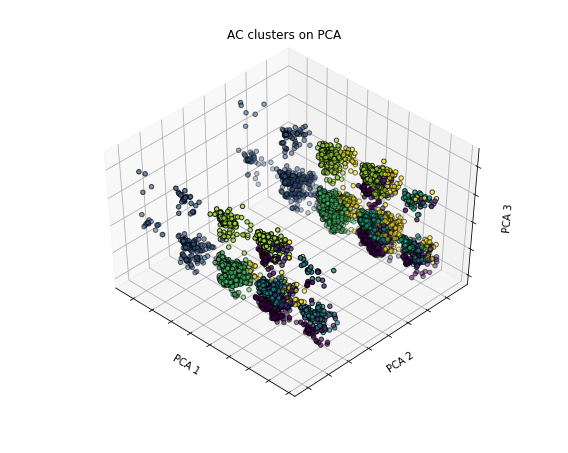

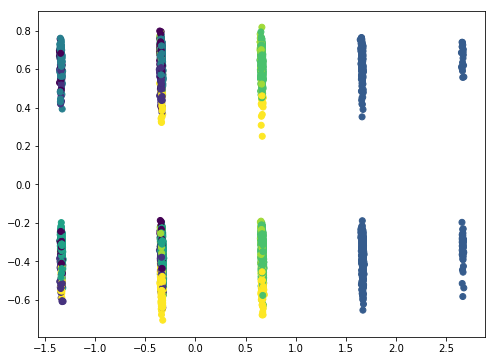

In [19]:
from sklearn import decomposition
# Import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
PC = decomposition.PCA(n_components=3).fit_transform(ready_cluster_data_cms_ip.values)
print(PC.shape)
fig = plt.figure(1, figsize=(8, 6))

ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
#use the cluster membership as labels
ax.scatter(PC[:, 0], PC[:, 1], PC[:, 2],
               c=label_cms_ip, edgecolor='k')
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title("AC clusters on PCA")
ax.dist = 12


PC2 = decomposition.PCA(n_components=2).fit_transform(ready_cluster_data_cms_ip.values)
print(PC2.shape)
fig2 = plt.figure(2, figsize=(8, 6))
plt.scatter(PC[:,0],PC[:,1],c=label_cms_ip)
plt.legend(loc=2)


### 8. TSNE visualization
   - optionally include/exclude the cluster label in generating TSNE dimensional reduction for visualization
   
### 9. Generate final output file after appending 2D TSNE dimensions for use in external BI viz tools

In [20]:
from __future__ import division, print_function, unicode_literals
from datetime import datetime
import numpy as np
import os
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

np.random.seed(42)

In [21]:
#Repetition in case kernel reset
#Exclude these columns from all analysis as they have already been one hot encoded or are summarry columns from beneficiary file.
EXCLUDE_COLUMNS = ['DESYNPUF_ID','CLM_ID','SEGMENT', 'CLM_FROM_DT', 'CLM_THRU_DT',
                  'CLM_ADMSN_DT', 'ADMTNG_ICD9_DGNS_CD', 'NCH_BENE_DSCHRG_DT', 'CLM_DRG_CD', 'ICD9_DGNS_CD_1', 'ICD9_DGNS_CD_2',
                  'ICD9_DGNS_CD_3', 'ICD9_DGNS_CD_4', 'ICD9_DGNS_CD_5', 'ICD9_DGNS_CD_6', 'ICD9_DGNS_CD_7', 'ICD9_DGNS_CD_8', 'ICD9_DGNS_CD_9', 'ICD9_DGNS_CD_10',
                  'ICD9_PRCDR_CD_1','ICD9_PRCDR_CD_2', 'ICD9_PRCDR_CD_3', 'ICD9_PRCDR_CD_4', 'ICD9_PRCDR_CD_5', 'ICD9_PRCDR_CD_6',
                  'BENE_ESRD_IND', 'BENE_BIRTH_DT', 'BENE_DEATH_DT', 'SP_ALZHDMTA', 'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD', 'SP_DEPRESSN', 'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA',
                  'MEDREIMB_IP','BENRES_IP','PPPYMT_IP', 'MEDREIMB_OP', 'BENRES_OP', 'PPPYMT_OP', 'MEDREIMB_CAR', 'PPPYMT_CAR', 'BENRES_CAR']

#Define Key Performance Indicator columns.  These are the key revenue performance measures that need to be optimized
KPI_INDEX_COLUMNS = ['CLM_PMT_AMT', 'NCH_PRMRY_PYR_CLM_PD_AMT', 'CLM_UTLZTN_DAY_CNT', 'LOG_CLM_PMT_AMT', 'LOG_NCH_PRMRY_PYR_CLM_PD_AMT']


#Metdata columns that are NOT use in pattern detection but used to EXPLAIN the patterns and provide root cause analysis
METADATA_COLUMNS = ['PRVDR_NUM', 'AT_PHYSN_NPI','OP_PHYSN_NPI', 'OT_PHYSN_NPI','SP_STATE_CODE','BENE_COUNTY_CD','BENE_SEX_IDENT_CD','BENE_RACE_CD',
                   'BENE_HI_CVRAGE_TOT_MONS', 'BENE_SMI_CVRAGE_TOT_MONS', 'BENE_HMO_CVRAGE_TOT_MONS', 'PLAN_CVRG_MOS_NUM', 'CLM_FROM_Year', 'CLM_FROM_Month', 'CLM_FROM_Day', 'CLM_FROM_DOW',
                   'CLM_PASS_THRU_PER_DIEM_AMT', 'NCH_BENE_IP_DDCTBL_AMT','NCH_BENE_BLOOD_DDCTBL_LBLTY_AM', 'NCH_BENE_PTA_COINSRNC_LBLTY_AM', 'LOG_CLM_PASS_THRU_PER_DIEM_AMT', 
                   'LOG_NCH_BENE_IP_DDCTBL_AMT', 'LOG_NCH_BENE_PTA_COINSRNC_LBLTY_AM', 'LOG_NCH_BENE_BLOOD_DDCTBL_LBLTY_AM']


In [22]:
#optinally run this to include / exclude labels in tns visualization
#KPI_INDEX_COLUMNS.append('cluster')
KPI_INDEX_COLUMNS

[u'CLM_PMT_AMT',
 u'NCH_PRMRY_PYR_CLM_PD_AMT',
 u'CLM_PASS_THRU_PER_DIEM_AMT',
 u'NCH_BENE_IP_DDCTBL_AMT',
 u'NCH_BENE_PTA_COINSRNC_LBLTY_AM',
 u'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM',
 u'CLM_UTLZTN_DAY_CNT',
 u'LOG_CLM_PMT_AMT',
 u'LOG_NCH_PRMRY_PYR_CLM_PD_AMT',
 u'LOG_CLM_PASS_THRU_PER_DIEM_AMT',
 u'LOG_NCH_BENE_IP_DDCTBL_AMT',
 u'LOG_NCH_BENE_PTA_COINSRNC_LBLTY_AM',
 u'LOG_NCH_BENE_BLOOD_DDCTBL_LBLTY_AM',
 u'CLM_FROM_Year',
 u'CLM_FROM_Month',
 u'CLM_FROM_Day',
 u'CLM_FROM_DOW']

In [23]:
def tsne_viz(tsne_data,KPI_INDEX_COLUMNS):

    Y = tsne_data["cluster"].values
    tsne_data_x = tsne_data.iloc[:,1:]
    X = tsne_data_x.drop(KPI_INDEX_COLUMNS, axis=1).values
    
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne_reduced = tsne.fit_transform(X)
    
    return X_tsne_reduced, Y

# TSNE Visualization: cms_ip Cluster

(-9.737003310777423, 8.948782886995016, -10.240725736143263, 9.918012604424089)

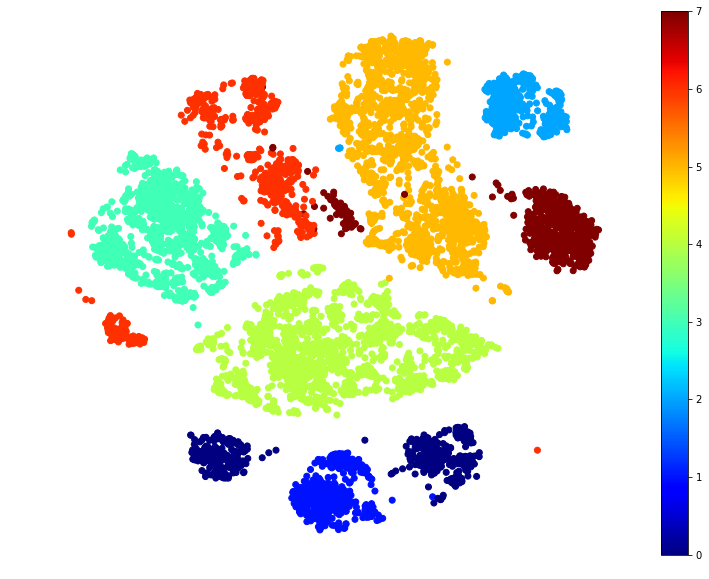

In [24]:
input_file = "cms_ip_cluster_output.csv"

output_file = "cms_ip_tsne_cluster_output.csv"

tsne_cluster_data = pd.read_csv(input_file)
tsne_output_data = tsne_cluster_data.copy()
tsne_cluster_data = tsne_cluster_data.drop(METADATA_COLUMNS, axis=1)
X_pca_tsne_reduced, Y = tsne_viz(tsne_cluster_data,KPI_INDEX_COLUMNS)    

plt.figure(figsize=(13,10))
plt.scatter(X_pca_tsne_reduced[:, 0], X_pca_tsne_reduced[:, 1],c=Y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

# TSNE decomposition that could improve the related but non-related clusters here
tsne_output_data['TSNE1'] = X_pca_tsne_reduced[:, 0]
tsne_output_data['TSNE2'] = X_pca_tsne_reduced[:, 1]
tsne_output_data.to_csv(output_file)

# Explanation

# Random Forest Explanation

# Reset Kernel

### 10. For each cluster, train a DRF on two classes: in cluster, out of cluster.  
   - output the Importance variables for each cluster to be used in external BI/ end user app

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from __future__ import division, print_function, unicode_literals
from datetime import datetime
import numpy as np
import os
import pandas as pd

from sklearn.preprocessing import StandardScaler, RobustScaler


%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

np.random.seed(42)

import h2o
from h2o.estimators import H2ORandomForestEstimator
h2o.init()

#define the number of clusters
n_cms_ip_cluster = 8

/usr/local/lib/python2.7/dist-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/usr/local/lib/python2.7/dist-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/usr/local/lib/python2.7/dist-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/usr/local/lib/python2.7/dist-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/usr/local/lib/python2.7/dist-packages/pandas/core/indexes/base.py:7: RuntimeWarning: numpy.dtype size changed, may indicate bi

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "11.0.1" 2018-10-16 LTS; Java(TM) SE Runtime Environment 18.9 (build 11.0.1+13-LTS); Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.1+13-LTS, mixed mode)
  Starting server from /usr/local/lib/python2.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpOcZ9DQ
  JVM stdout: /tmp/tmpOcZ9DQ/h2o_root_started_from_python.out
  JVM stderr: /tmp/tmpOcZ9DQ/h2o_root_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,04 secs
H2O cluster timezone:,UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.1
H2O cluster version age:,12 days
H2O cluster name:,H2O_from_python_root_vo6fkg
H2O cluster total nodes:,1
H2O cluster free memory:,6.381 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [3]:
KPI_INDEX_COLUMNS = ['CLM_PMT_AMT', 'NCH_PRMRY_PYR_CLM_PD_AMT', 'CLM_PASS_THRU_PER_DIEM_AMT', 'NCH_BENE_IP_DDCTBL_AMT', 'NCH_BENE_PTA_COINSRNC_LBLTY_AM',
                     'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM', 'CLM_UTLZTN_DAY_CNT', 'LOG_CLM_PMT_AMT', 'LOG_NCH_PRMRY_PYR_CLM_PD_AMT', 'LOG_CLM_PASS_THRU_PER_DIEM_AMT',
                     'LOG_NCH_BENE_IP_DDCTBL_AMT', 'LOG_NCH_BENE_PTA_COINSRNC_LBLTY_AM', 'LOG_NCH_BENE_BLOOD_DDCTBL_LBLTY_AM', 'CLM_FROM_Year', 'CLM_FROM_Month', 'CLM_FROM_Day', 'CLM_FROM_DOW']

In [4]:
KPI_INDEX_COLUMNS.append('cluster')
KPI_INDEX_COLUMNS

[u'CLM_PMT_AMT',
 u'NCH_PRMRY_PYR_CLM_PD_AMT',
 u'CLM_PASS_THRU_PER_DIEM_AMT',
 u'NCH_BENE_IP_DDCTBL_AMT',
 u'NCH_BENE_PTA_COINSRNC_LBLTY_AM',
 u'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM',
 u'CLM_UTLZTN_DAY_CNT',
 u'LOG_CLM_PMT_AMT',
 u'LOG_NCH_PRMRY_PYR_CLM_PD_AMT',
 u'LOG_CLM_PASS_THRU_PER_DIEM_AMT',
 u'LOG_NCH_BENE_IP_DDCTBL_AMT',
 u'LOG_NCH_BENE_PTA_COINSRNC_LBLTY_AM',
 u'LOG_NCH_BENE_BLOOD_DDCTBL_LBLTY_AM',
 u'CLM_FROM_Year',
 u'CLM_FROM_Month',
 u'CLM_FROM_Day',
 u'CLM_FROM_DOW',
 u'cluster']

# Explanation: cms_ip Clusters. Delete the rfout file.

In [5]:
cluster_cms_ip = pd.read_csv('cms_ip_cluster_output.csv')
cluster_cms_ip_x = cluster_cms_ip.iloc[:,1:]
cluster_cms_ip_predictors = cluster_cms_ip_x.drop(KPI_INDEX_COLUMNS, axis=1)
label_cms_ip = cluster_cms_ip["cluster"].values
ntree=  500
depth = 30
nfold = 10
#tempoutput = pd.DataFrame(columns=['variable','relative_importance','scaled_importance','percentage','cluster_member','data_segment'])
output_file = open('rfout_cms_ip.csv','a')
for i in range(n_cms_ip_cluster):
    rf_cms_ip_model = H2ORandomForestEstimator(ntrees=ntree, max_depth=depth, nfolds=nfold)
    predictors= cluster_cms_ip_predictors.columns.values.tolist()
    response = "cluster"
    classlabels = np.where(label_cms_ip==i,1,0)
    rf_df = h2o.H2OFrame(cluster_cms_ip_predictors)
    rf_df.set_names(predictors)
    rf_df[response]=h2o.H2OFrame(classlabels)
    train,valid = rf_df.split_frame(ratios = [0.8], seed=42)
    rf_cms_ip_model.train(x=predictors,y=response, training_frame = train, validation_frame = valid)
#    output_df = rf_cms_ip_model._model_json['output']['variable_importances'].as_data_frame()
    output_df["cluster_member"] = i
    output_df["data_segment"] = "cms_ip"
    output_df
    if i==0:
        output_df.to_csv(output_file, header=True)
    else:
        output_df.to_csv(output_file, header=False)

output_file.close()

/usr/local/lib/python2.7/dist-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%


PRVDR_NUM AT_PHYSN_NPI OP_PHYSN_NPI OT_PHYSN_NPI proc_9904 proc_8154 proc_3893 proc_66 proc_3995 proc_4516 proc_3722 proc_9671 proc_8872 proc_8151 proc_4513 proc_9390 proc_9672 proc_7935 proc_5123 proc_8152 proc_3491 proc_9339 proc_3812 proc_3950 proc_3772 proc_8622 proc_4523 proc_309 proc_387 proc_8108 proc_9921 proc_4525 proc_5491 proc_4311 proc_5794 proc_7915 proc_8703 proc_9604 proc_3324 proc_9929 proc_8102 proc_331 proc_6029 proc_3612 proc_4573 proc_3723 proc_8659 proc_7936 proc_3895 proc_8604 proc_4542 proc_3783 proc_3521 proc_9462 proc_8891 proc_9925 proc_9907 proc_4576 proc_3613 proc_311 proc_51 proc_8051 proc_4562 proc_3794 proc_4443 proc_3971 proc_9607 proc_6849 proc_3929 proc_7855 proc_5749 proc_966 proc_5122 proc_5459 proc_3404 proc_3734 proc_8741 proc_8180 proc_605 proc_8191 proc_9955 proc_8801 proc_7749 proc_8628 proc_3927 proc_3327 proc_8411 proc_9962 proc_3771 proc_5185 proc_8627 proc_8944 proc_9915 proc_8415 proc_4131 proc_9394 proc_598 proc_131 proc_3249 proc_6859 proc_8417 proc_560 proc_3949 proc_5551 proc_3522 proc_8954 proc_8607 proc_3898 proc_1733 proc_8192 proc_3611 proc_9952 proc_8166 proc_5569 proc_3615 proc_3326 proc_9229 proc_9910 proc_9905 proc_9396 proc_3761 proc_61 proc_9465 proc_8877 proc_9961 proc_8543 proc_5361 proc_7931 proc_70 proc_8605 proc_5498 proc_9919 proc_8841 proc_5503 proc_4011 proc_8949 proc_392 proc_5732 proc_3614 proc_5011 proc_4701 proc_9960 proc_9427 proc_8952 proc_8945 proc_8669 proc_4292 proc_3979 proc_4438 proc_80 proc_4524 proc_OTHER_PROC dx_486 dx_V5789 dx_41401 dx_389 dx_49121 dx_4280 dx_5990 dx_42731 dx_41071 dx_71536 dx_5849 dx_43491 dx_51881 dx_78659 dx_7802 dx_5070 dx_27651 dx_6826 dx_42823 dx_4359 dx_82021 dx_71535 dx_5789 dx_43310 dx_49122 dx_41519 dx_5770 dx_56211 dx_78650 dx_49322 dx_71596 dx_51884 dx_42833 dx_5609 dx_42781 dx_29570 dx_845 dx_8208 dx_25080 dx_42789 dx_3310 dx_72402 dx_5589 dx_2761 dx_99859 dx_82009 dx_56081 dx_4580 dx_56212 dx_3842 dx_45341 dx_57400 dx_73313 dx_4241 dx_72210 dx_42821 dx_42831 dx_431 dx_4414 dx_43411 dx_40391 dx_78097 dx_2767 dx_4660 dx_42732 dx_29633 dx_5601 dx_4271 dx_5119 dx_42843 dx_185 dx_99662 dx_2859 dx_41400 dx_1623 dx_60001 dx_34590 dx_71516 dx_71595 dx_41041 dx_3849 dx_8082 dx_4019 dx_78039 dx_5781 dx_42830 dx_72252 dx_53140 dx_88 dx_2948 dx_V5811 dx_57410 dx_44021 dx_2989 dx_99673 dx_99664 dx_41011 dx_8054 dx_49392 dx_29530 dx_44024 dx_5921 dx_5579 dx_29534 dx_7804 dx_4260 dx_1629 dx_7213 dx_4589 dx_380 dx_5722 dx_41091 dx_2809 dx_59080 dx_53081 dx_25002 dx_40491 dx_29650 dx_40291 dx_3811 dx_99666 dx_25070 dx_85221 dx_1625 dx_1983 dx_99642 dx_41402 dx_43311 dx_2536 dx_515 dx_29574 dx_29181 dx_2113 dx_99672 dx_55321 dx_6823 dx_72888 dx_56089 dx_45342 dx_27801 dx_99931 dx_6827 dx_70703 dx_56400 dx_53240 dx_6822 dx_1985 dx_311 dx_78079 dx_78060 dx_53783 dx_25082 dx_4111 dx_2800 dx_45340 dx_29680 dx_29634 dx_1820 dx_99674 dx_57420 dx_4821 dx_1977 dx_71531 dx_44023 dx_29620 dx_99811 dx_78701 dx_34831 dx_29630 dx_28800 dx_7211 dx_7907 dx_1890 dx_56039 dx_25060 dx_5845 dx_3812 dx_8052 dx_5715 dx_5920 dx_2920 dx_99649 dx_78900 dx_7210 dx_1749 dx_82022 dx_59010 dx_99681 dx_5750 dx_2766 dx_29690 dx_28262 dx_388 dx_78791 dx_56985 dx_42820 dx_40390 dx_5693 dx_2851 dx_39891 dx_29532 dx_2768 dx_485 dx_99812 dx_48283 dx_48242 dx_9974 dx_7384 dx_5570 dx_4552 dx_4240 dx_4010 dx_99641 dx_78009 dx_8244 dx_490 dx_71515 dx_34830 dx_2760 dx_85220 dx_48241 dx_44022 dx_4321 dx_53550 dx_7999 dx_430 dx_44422 dx_1536 dx_78652 dx_53551 dx_34982 dx_25013 dx_4148 dx_78906 dx_55221 dx_5533 dx_1534 dx_496 dx_29644 dx_7837 dx_5409 dx_1541 dx_481 dx_82020 dx_6184 dx_5712 dx_82101 dx_38611 dx_5780 dx_5185 dx_4829 dx_99661 dx_73342 dx_6820 dx_3320 dx_1970 dx_42822 dx_7242 dx_6185 dx_4210 dx_4139 dx_45829 dx_20300 dx_7220 dx_78609 dx_78605 dx_72271 dx_53541 dx_49390 dx_29590 dx_9961 dx_5128 dx_2841 dx_1830 dx_1533 dx_42 dx_81200 dx_33182 dx_25062 dx_9694 dx_8246 dx_5856 dx_4270 dx_4254 dx_1579 dx_82300 dx_78909 dx_56213 dx_20500 dx_7812 dx_6824 dx_1889 dx_530

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


,variable,relative_importance,scaled_importance,percentage,cluster_member,data_segment
0,dx_42731,148261.281250,1.000000,0.639699,0,cms_ip
1,BENE_Age_Group,48896.652344,0.329801,0.210973,0,cms_ip
2,OT_PHYSN_NPI,11847.906250,0.079912,0.051120,0,cms_ip
3,dx_5990,7195.123535,0.048530,0.031045,0,cms_ip
4,dx_5849,6788.298340,0.045786,0.029289,0,cms_ip
5,dx_4019,3522.518799,0.023759,0.015199,0,cms_ip
6,AT_PHYSN_NPI,452.981415,0.003055,0.001954,0,cms_ip
7,PRVDR_NUM,340.435730,0.002296,0.001469,0,cms_ip
8,BENE_COUNTY_CD,318.697845,0.002150,0.001375,0,cms_ip
9,OP_PHYSN_NPI,295.178619,0.001991,0.001274,0,cms_ip


Parse progress: |█████████████████████████████████████████████████████████| 100%


PRVDR_NUM AT_PHYSN_NPI OP_PHYSN_NPI OT_PHYSN_NPI proc_9904 proc_8154 proc_3893 proc_66 proc_3995 proc_4516 proc_3722 proc_9671 proc_8872 proc_8151 proc_4513 proc_9390 proc_9672 proc_7935 proc_5123 proc_8152 proc_3491 proc_9339 proc_3812 proc_3950 proc_3772 proc_8622 proc_4523 proc_309 proc_387 proc_8108 proc_9921 proc_4525 proc_5491 proc_4311 proc_5794 proc_7915 proc_8703 proc_9604 proc_3324 proc_9929 proc_8102 proc_331 proc_6029 proc_3612 proc_4573 proc_3723 proc_8659 proc_7936 proc_3895 proc_8604 proc_4542 proc_3783 proc_3521 proc_9462 proc_8891 proc_9925 proc_9907 proc_4576 proc_3613 proc_311 proc_51 proc_8051 proc_4562 proc_3794 proc_4443 proc_3971 proc_9607 proc_6849 proc_3929 proc_7855 proc_5749 proc_966 proc_5122 proc_5459 proc_3404 proc_3734 proc_8741 proc_8180 proc_605 proc_8191 proc_9955 proc_8801 proc_7749 proc_8628 proc_3927 proc_3327 proc_8411 proc_9962 proc_3771 proc_5185 proc_8627 proc_8944 proc_9915 proc_8415 proc_4131 proc_9394 proc_598 proc_131 proc_3249 proc_6859 proc_8417 proc_560 proc_3949 proc_5551 proc_3522 proc_8954 proc_8607 proc_3898 proc_1733 proc_8192 proc_3611 proc_9952 proc_8166 proc_5569 proc_3615 proc_3326 proc_9229 proc_9910 proc_9905 proc_9396 proc_3761 proc_61 proc_9465 proc_8877 proc_9961 proc_8543 proc_5361 proc_7931 proc_70 proc_8605 proc_5498 proc_9919 proc_8841 proc_5503 proc_4011 proc_8949 proc_392 proc_5732 proc_3614 proc_5011 proc_4701 proc_9960 proc_9427 proc_8952 proc_8945 proc_8669 proc_4292 proc_3979 proc_4438 proc_80 proc_4524 proc_OTHER_PROC dx_486 dx_V5789 dx_41401 dx_389 dx_49121 dx_4280 dx_5990 dx_42731 dx_41071 dx_71536 dx_5849 dx_43491 dx_51881 dx_78659 dx_7802 dx_5070 dx_27651 dx_6826 dx_42823 dx_4359 dx_82021 dx_71535 dx_5789 dx_43310 dx_49122 dx_41519 dx_5770 dx_56211 dx_78650 dx_49322 dx_71596 dx_51884 dx_42833 dx_5609 dx_42781 dx_29570 dx_845 dx_8208 dx_25080 dx_42789 dx_3310 dx_72402 dx_5589 dx_2761 dx_99859 dx_82009 dx_56081 dx_4580 dx_56212 dx_3842 dx_45341 dx_57400 dx_73313 dx_4241 dx_72210 dx_42821 dx_42831 dx_431 dx_4414 dx_43411 dx_40391 dx_78097 dx_2767 dx_4660 dx_42732 dx_29633 dx_5601 dx_4271 dx_5119 dx_42843 dx_185 dx_99662 dx_2859 dx_41400 dx_1623 dx_60001 dx_34590 dx_71516 dx_71595 dx_41041 dx_3849 dx_8082 dx_4019 dx_78039 dx_5781 dx_42830 dx_72252 dx_53140 dx_88 dx_2948 dx_V5811 dx_57410 dx_44021 dx_2989 dx_99673 dx_99664 dx_41011 dx_8054 dx_49392 dx_29530 dx_44024 dx_5921 dx_5579 dx_29534 dx_7804 dx_4260 dx_1629 dx_7213 dx_4589 dx_380 dx_5722 dx_41091 dx_2809 dx_59080 dx_53081 dx_25002 dx_40491 dx_29650 dx_40291 dx_3811 dx_99666 dx_25070 dx_85221 dx_1625 dx_1983 dx_99642 dx_41402 dx_43311 dx_2536 dx_515 dx_29574 dx_29181 dx_2113 dx_99672 dx_55321 dx_6823 dx_72888 dx_56089 dx_45342 dx_27801 dx_99931 dx_6827 dx_70703 dx_56400 dx_53240 dx_6822 dx_1985 dx_311 dx_78079 dx_78060 dx_53783 dx_25082 dx_4111 dx_2800 dx_45340 dx_29680 dx_29634 dx_1820 dx_99674 dx_57420 dx_4821 dx_1977 dx_71531 dx_44023 dx_29620 dx_99811 dx_78701 dx_34831 dx_29630 dx_28800 dx_7211 dx_7907 dx_1890 dx_56039 dx_25060 dx_5845 dx_3812 dx_8052 dx_5715 dx_5920 dx_2920 dx_99649 dx_78900 dx_7210 dx_1749 dx_82022 dx_59010 dx_99681 dx_5750 dx_2766 dx_29690 dx_28262 dx_388 dx_78791 dx_56985 dx_42820 dx_40390 dx_5693 dx_2851 dx_39891 dx_29532 dx_2768 dx_485 dx_99812 dx_48283 dx_48242 dx_9974 dx_7384 dx_5570 dx_4552 dx_4240 dx_4010 dx_99641 dx_78009 dx_8244 dx_490 dx_71515 dx_34830 dx_2760 dx_85220 dx_48241 dx_44022 dx_4321 dx_53550 dx_7999 dx_430 dx_44422 dx_1536 dx_78652 dx_53551 dx_34982 dx_25013 dx_4148 dx_78906 dx_55221 dx_5533 dx_1534 dx_496 dx_29644 dx_7837 dx_5409 dx_1541 dx_481 dx_82020 dx_6184 dx_5712 dx_82101 dx_38611 dx_5780 dx_5185 dx_4829 dx_99661 dx_73342 dx_6820 dx_3320 dx_1970 dx_42822 dx_7242 dx_6185 dx_4210 dx_4139 dx_45829 dx_20300 dx_7220 dx_78609 dx_78605 dx_72271 dx_53541 dx_49390 dx_29590 dx_9961 dx_5128 dx_2841 dx_1830 dx_1533 dx_42 dx_81200 dx_33182 dx_25062 dx_9694 dx_8246 dx_5856 dx_4270 dx_4254 dx_1579 dx_82300 dx_78909 dx_56213 dx_20500 dx_7812 dx_6824 dx_1889 dx_530

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


,variable,relative_importance,scaled_importance,percentage,cluster_member,data_segment
0,dx_5990,123693.523438,1.000000,0.640262,1,cms_ip
1,BENE_Age_Group,35499.226562,0.286993,0.183751,1,cms_ip
2,OT_PHYSN_NPI,10360.476562,0.083759,0.053628,1,cms_ip
3,dx_5849,10161.772461,0.082153,0.052599,1,cms_ip
4,dx_4019,4611.190918,0.037279,0.023868,1,cms_ip
5,dx_42731,1969.214722,0.015920,0.010193,1,cms_ip
6,PRVDR_NUM,879.765686,0.007112,0.004554,1,cms_ip
7,BENE_COUNTY_CD,663.912598,0.005367,0.003437,1,cms_ip
8,AT_PHYSN_NPI,482.107819,0.003898,0.002495,1,cms_ip
9,OP_PHYSN_NPI,411.591736,0.003328,0.002130,1,cms_ip


Parse progress: |█████████████████████████████████████████████████████████| 100%


PRVDR_NUM AT_PHYSN_NPI OP_PHYSN_NPI OT_PHYSN_NPI proc_9904 proc_8154 proc_3893 proc_66 proc_3995 proc_4516 proc_3722 proc_9671 proc_8872 proc_8151 proc_4513 proc_9390 proc_9672 proc_7935 proc_5123 proc_8152 proc_3491 proc_9339 proc_3812 proc_3950 proc_3772 proc_8622 proc_4523 proc_309 proc_387 proc_8108 proc_9921 proc_4525 proc_5491 proc_4311 proc_5794 proc_7915 proc_8703 proc_9604 proc_3324 proc_9929 proc_8102 proc_331 proc_6029 proc_3612 proc_4573 proc_3723 proc_8659 proc_7936 proc_3895 proc_8604 proc_4542 proc_3783 proc_3521 proc_9462 proc_8891 proc_9925 proc_9907 proc_4576 proc_3613 proc_311 proc_51 proc_8051 proc_4562 proc_3794 proc_4443 proc_3971 proc_9607 proc_6849 proc_3929 proc_7855 proc_5749 proc_966 proc_5122 proc_5459 proc_3404 proc_3734 proc_8741 proc_8180 proc_605 proc_8191 proc_9955 proc_8801 proc_7749 proc_8628 proc_3927 proc_3327 proc_8411 proc_9962 proc_3771 proc_5185 proc_8627 proc_8944 proc_9915 proc_8415 proc_4131 proc_9394 proc_598 proc_131 proc_3249 proc_6859 proc_8417 proc_560 proc_3949 proc_5551 proc_3522 proc_8954 proc_8607 proc_3898 proc_1733 proc_8192 proc_3611 proc_9952 proc_8166 proc_5569 proc_3615 proc_3326 proc_9229 proc_9910 proc_9905 proc_9396 proc_3761 proc_61 proc_9465 proc_8877 proc_9961 proc_8543 proc_5361 proc_7931 proc_70 proc_8605 proc_5498 proc_9919 proc_8841 proc_5503 proc_4011 proc_8949 proc_392 proc_5732 proc_3614 proc_5011 proc_4701 proc_9960 proc_9427 proc_8952 proc_8945 proc_8669 proc_4292 proc_3979 proc_4438 proc_80 proc_4524 proc_OTHER_PROC dx_486 dx_V5789 dx_41401 dx_389 dx_49121 dx_4280 dx_5990 dx_42731 dx_41071 dx_71536 dx_5849 dx_43491 dx_51881 dx_78659 dx_7802 dx_5070 dx_27651 dx_6826 dx_42823 dx_4359 dx_82021 dx_71535 dx_5789 dx_43310 dx_49122 dx_41519 dx_5770 dx_56211 dx_78650 dx_49322 dx_71596 dx_51884 dx_42833 dx_5609 dx_42781 dx_29570 dx_845 dx_8208 dx_25080 dx_42789 dx_3310 dx_72402 dx_5589 dx_2761 dx_99859 dx_82009 dx_56081 dx_4580 dx_56212 dx_3842 dx_45341 dx_57400 dx_73313 dx_4241 dx_72210 dx_42821 dx_42831 dx_431 dx_4414 dx_43411 dx_40391 dx_78097 dx_2767 dx_4660 dx_42732 dx_29633 dx_5601 dx_4271 dx_5119 dx_42843 dx_185 dx_99662 dx_2859 dx_41400 dx_1623 dx_60001 dx_34590 dx_71516 dx_71595 dx_41041 dx_3849 dx_8082 dx_4019 dx_78039 dx_5781 dx_42830 dx_72252 dx_53140 dx_88 dx_2948 dx_V5811 dx_57410 dx_44021 dx_2989 dx_99673 dx_99664 dx_41011 dx_8054 dx_49392 dx_29530 dx_44024 dx_5921 dx_5579 dx_29534 dx_7804 dx_4260 dx_1629 dx_7213 dx_4589 dx_380 dx_5722 dx_41091 dx_2809 dx_59080 dx_53081 dx_25002 dx_40491 dx_29650 dx_40291 dx_3811 dx_99666 dx_25070 dx_85221 dx_1625 dx_1983 dx_99642 dx_41402 dx_43311 dx_2536 dx_515 dx_29574 dx_29181 dx_2113 dx_99672 dx_55321 dx_6823 dx_72888 dx_56089 dx_45342 dx_27801 dx_99931 dx_6827 dx_70703 dx_56400 dx_53240 dx_6822 dx_1985 dx_311 dx_78079 dx_78060 dx_53783 dx_25082 dx_4111 dx_2800 dx_45340 dx_29680 dx_29634 dx_1820 dx_99674 dx_57420 dx_4821 dx_1977 dx_71531 dx_44023 dx_29620 dx_99811 dx_78701 dx_34831 dx_29630 dx_28800 dx_7211 dx_7907 dx_1890 dx_56039 dx_25060 dx_5845 dx_3812 dx_8052 dx_5715 dx_5920 dx_2920 dx_99649 dx_78900 dx_7210 dx_1749 dx_82022 dx_59010 dx_99681 dx_5750 dx_2766 dx_29690 dx_28262 dx_388 dx_78791 dx_56985 dx_42820 dx_40390 dx_5693 dx_2851 dx_39891 dx_29532 dx_2768 dx_485 dx_99812 dx_48283 dx_48242 dx_9974 dx_7384 dx_5570 dx_4552 dx_4240 dx_4010 dx_99641 dx_78009 dx_8244 dx_490 dx_71515 dx_34830 dx_2760 dx_85220 dx_48241 dx_44022 dx_4321 dx_53550 dx_7999 dx_430 dx_44422 dx_1536 dx_78652 dx_53551 dx_34982 dx_25013 dx_4148 dx_78906 dx_55221 dx_5533 dx_1534 dx_496 dx_29644 dx_7837 dx_5409 dx_1541 dx_481 dx_82020 dx_6184 dx_5712 dx_82101 dx_38611 dx_5780 dx_5185 dx_4829 dx_99661 dx_73342 dx_6820 dx_3320 dx_1970 dx_42822 dx_7242 dx_6185 dx_4210 dx_4139 dx_45829 dx_20300 dx_7220 dx_78609 dx_78605 dx_72271 dx_53541 dx_49390 dx_29590 dx_9961 dx_5128 dx_2841 dx_1830 dx_1533 dx_42 dx_81200 dx_33182 dx_25062 dx_9694 dx_8246 dx_5856 dx_4270 dx_4254 dx_1579 dx_82300 dx_78909 dx_56213 dx_20500 dx_7812 dx_6824 dx_1889 dx_530

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


,variable,relative_importance,scaled_importance,percentage,cluster_member,data_segment
0,BENE_Age_Group,184201.968750,1.000000,0.951487,2,cms_ip
1,OT_PHYSN_NPI,6345.959961,0.034451,0.032780,2,cms_ip
2,PRVDR_NUM,912.127502,0.004952,0.004712,2,cms_ip
3,BENE_RACE_CD,471.629547,0.002560,0.002436,2,cms_ip
4,PLAN_CVRG_MOS_NUM,317.417664,0.001723,0.001640,2,cms_ip
5,BENE_COUNTY_CD,208.971420,0.001134,0.001079,2,cms_ip
6,proc_966,84.114754,0.000457,0.000434,2,cms_ip
7,OP_PHYSN_NPI,78.090729,0.000424,0.000403,2,cms_ip
8,AT_PHYSN_NPI,52.502270,0.000285,0.000271,2,cms_ip
9,dx_72271,39.566639,0.000215,0.000204,2,cms_ip


Parse progress: |█████████████████████████████████████████████████████████| 100%


PRVDR_NUM AT_PHYSN_NPI OP_PHYSN_NPI OT_PHYSN_NPI proc_9904 proc_8154 proc_3893 proc_66 proc_3995 proc_4516 proc_3722 proc_9671 proc_8872 proc_8151 proc_4513 proc_9390 proc_9672 proc_7935 proc_5123 proc_8152 proc_3491 proc_9339 proc_3812 proc_3950 proc_3772 proc_8622 proc_4523 proc_309 proc_387 proc_8108 proc_9921 proc_4525 proc_5491 proc_4311 proc_5794 proc_7915 proc_8703 proc_9604 proc_3324 proc_9929 proc_8102 proc_331 proc_6029 proc_3612 proc_4573 proc_3723 proc_8659 proc_7936 proc_3895 proc_8604 proc_4542 proc_3783 proc_3521 proc_9462 proc_8891 proc_9925 proc_9907 proc_4576 proc_3613 proc_311 proc_51 proc_8051 proc_4562 proc_3794 proc_4443 proc_3971 proc_9607 proc_6849 proc_3929 proc_7855 proc_5749 proc_966 proc_5122 proc_5459 proc_3404 proc_3734 proc_8741 proc_8180 proc_605 proc_8191 proc_9955 proc_8801 proc_7749 proc_8628 proc_3927 proc_3327 proc_8411 proc_9962 proc_3771 proc_5185 proc_8627 proc_8944 proc_9915 proc_8415 proc_4131 proc_9394 proc_598 proc_131 proc_3249 proc_6859 proc_8417 proc_560 proc_3949 proc_5551 proc_3522 proc_8954 proc_8607 proc_3898 proc_1733 proc_8192 proc_3611 proc_9952 proc_8166 proc_5569 proc_3615 proc_3326 proc_9229 proc_9910 proc_9905 proc_9396 proc_3761 proc_61 proc_9465 proc_8877 proc_9961 proc_8543 proc_5361 proc_7931 proc_70 proc_8605 proc_5498 proc_9919 proc_8841 proc_5503 proc_4011 proc_8949 proc_392 proc_5732 proc_3614 proc_5011 proc_4701 proc_9960 proc_9427 proc_8952 proc_8945 proc_8669 proc_4292 proc_3979 proc_4438 proc_80 proc_4524 proc_OTHER_PROC dx_486 dx_V5789 dx_41401 dx_389 dx_49121 dx_4280 dx_5990 dx_42731 dx_41071 dx_71536 dx_5849 dx_43491 dx_51881 dx_78659 dx_7802 dx_5070 dx_27651 dx_6826 dx_42823 dx_4359 dx_82021 dx_71535 dx_5789 dx_43310 dx_49122 dx_41519 dx_5770 dx_56211 dx_78650 dx_49322 dx_71596 dx_51884 dx_42833 dx_5609 dx_42781 dx_29570 dx_845 dx_8208 dx_25080 dx_42789 dx_3310 dx_72402 dx_5589 dx_2761 dx_99859 dx_82009 dx_56081 dx_4580 dx_56212 dx_3842 dx_45341 dx_57400 dx_73313 dx_4241 dx_72210 dx_42821 dx_42831 dx_431 dx_4414 dx_43411 dx_40391 dx_78097 dx_2767 dx_4660 dx_42732 dx_29633 dx_5601 dx_4271 dx_5119 dx_42843 dx_185 dx_99662 dx_2859 dx_41400 dx_1623 dx_60001 dx_34590 dx_71516 dx_71595 dx_41041 dx_3849 dx_8082 dx_4019 dx_78039 dx_5781 dx_42830 dx_72252 dx_53140 dx_88 dx_2948 dx_V5811 dx_57410 dx_44021 dx_2989 dx_99673 dx_99664 dx_41011 dx_8054 dx_49392 dx_29530 dx_44024 dx_5921 dx_5579 dx_29534 dx_7804 dx_4260 dx_1629 dx_7213 dx_4589 dx_380 dx_5722 dx_41091 dx_2809 dx_59080 dx_53081 dx_25002 dx_40491 dx_29650 dx_40291 dx_3811 dx_99666 dx_25070 dx_85221 dx_1625 dx_1983 dx_99642 dx_41402 dx_43311 dx_2536 dx_515 dx_29574 dx_29181 dx_2113 dx_99672 dx_55321 dx_6823 dx_72888 dx_56089 dx_45342 dx_27801 dx_99931 dx_6827 dx_70703 dx_56400 dx_53240 dx_6822 dx_1985 dx_311 dx_78079 dx_78060 dx_53783 dx_25082 dx_4111 dx_2800 dx_45340 dx_29680 dx_29634 dx_1820 dx_99674 dx_57420 dx_4821 dx_1977 dx_71531 dx_44023 dx_29620 dx_99811 dx_78701 dx_34831 dx_29630 dx_28800 dx_7211 dx_7907 dx_1890 dx_56039 dx_25060 dx_5845 dx_3812 dx_8052 dx_5715 dx_5920 dx_2920 dx_99649 dx_78900 dx_7210 dx_1749 dx_82022 dx_59010 dx_99681 dx_5750 dx_2766 dx_29690 dx_28262 dx_388 dx_78791 dx_56985 dx_42820 dx_40390 dx_5693 dx_2851 dx_39891 dx_29532 dx_2768 dx_485 dx_99812 dx_48283 dx_48242 dx_9974 dx_7384 dx_5570 dx_4552 dx_4240 dx_4010 dx_99641 dx_78009 dx_8244 dx_490 dx_71515 dx_34830 dx_2760 dx_85220 dx_48241 dx_44022 dx_4321 dx_53550 dx_7999 dx_430 dx_44422 dx_1536 dx_78652 dx_53551 dx_34982 dx_25013 dx_4148 dx_78906 dx_55221 dx_5533 dx_1534 dx_496 dx_29644 dx_7837 dx_5409 dx_1541 dx_481 dx_82020 dx_6184 dx_5712 dx_82101 dx_38611 dx_5780 dx_5185 dx_4829 dx_99661 dx_73342 dx_6820 dx_3320 dx_1970 dx_42822 dx_7242 dx_6185 dx_4210 dx_4139 dx_45829 dx_20300 dx_7220 dx_78609 dx_78605 dx_72271 dx_53541 dx_49390 dx_29590 dx_9961 dx_5128 dx_2841 dx_1830 dx_1533 dx_42 dx_81200 dx_33182 dx_25062 dx_9694 dx_8246 dx_5856 dx_4270 dx_4254 dx_1579 dx_82300 dx_78909 dx_56213 dx_20500 dx_7812 dx_6824 dx_1889 dx_530

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


,variable,relative_importance,scaled_importance,percentage,cluster_member,data_segment
0,dx_4019,140357.140625,1.000000,0.423034,3,cms_ip
1,BENE_Age_Group,70216.562500,0.500271,0.211632,3,cms_ip
2,dx_42731,35507.265625,0.252978,0.107018,3,cms_ip
3,proc_OTHER_PROC,31982.724609,0.227867,0.096395,3,cms_ip
4,dx_5990,24630.144531,0.175482,0.074235,3,cms_ip
5,OT_PHYSN_NPI,14361.382812,0.102320,0.043285,3,cms_ip
6,dx_5849,4299.127441,0.030630,0.012958,3,cms_ip
7,OP_PHYSN_NPI,1875.544312,0.013363,0.005653,3,cms_ip
8,PRVDR_NUM,1268.640381,0.009039,0.003824,3,cms_ip
9,SCALED_CLM_PMT_AMT,976.532043,0.006957,0.002943,3,cms_ip


Parse progress: |█████████████████████████████████████████████████████████| 100%


PRVDR_NUM AT_PHYSN_NPI OP_PHYSN_NPI OT_PHYSN_NPI proc_9904 proc_8154 proc_3893 proc_66 proc_3995 proc_4516 proc_3722 proc_9671 proc_8872 proc_8151 proc_4513 proc_9390 proc_9672 proc_7935 proc_5123 proc_8152 proc_3491 proc_9339 proc_3812 proc_3950 proc_3772 proc_8622 proc_4523 proc_309 proc_387 proc_8108 proc_9921 proc_4525 proc_5491 proc_4311 proc_5794 proc_7915 proc_8703 proc_9604 proc_3324 proc_9929 proc_8102 proc_331 proc_6029 proc_3612 proc_4573 proc_3723 proc_8659 proc_7936 proc_3895 proc_8604 proc_4542 proc_3783 proc_3521 proc_9462 proc_8891 proc_9925 proc_9907 proc_4576 proc_3613 proc_311 proc_51 proc_8051 proc_4562 proc_3794 proc_4443 proc_3971 proc_9607 proc_6849 proc_3929 proc_7855 proc_5749 proc_966 proc_5122 proc_5459 proc_3404 proc_3734 proc_8741 proc_8180 proc_605 proc_8191 proc_9955 proc_8801 proc_7749 proc_8628 proc_3927 proc_3327 proc_8411 proc_9962 proc_3771 proc_5185 proc_8627 proc_8944 proc_9915 proc_8415 proc_4131 proc_9394 proc_598 proc_131 proc_3249 proc_6859 proc_8417 proc_560 proc_3949 proc_5551 proc_3522 proc_8954 proc_8607 proc_3898 proc_1733 proc_8192 proc_3611 proc_9952 proc_8166 proc_5569 proc_3615 proc_3326 proc_9229 proc_9910 proc_9905 proc_9396 proc_3761 proc_61 proc_9465 proc_8877 proc_9961 proc_8543 proc_5361 proc_7931 proc_70 proc_8605 proc_5498 proc_9919 proc_8841 proc_5503 proc_4011 proc_8949 proc_392 proc_5732 proc_3614 proc_5011 proc_4701 proc_9960 proc_9427 proc_8952 proc_8945 proc_8669 proc_4292 proc_3979 proc_4438 proc_80 proc_4524 proc_OTHER_PROC dx_486 dx_V5789 dx_41401 dx_389 dx_49121 dx_4280 dx_5990 dx_42731 dx_41071 dx_71536 dx_5849 dx_43491 dx_51881 dx_78659 dx_7802 dx_5070 dx_27651 dx_6826 dx_42823 dx_4359 dx_82021 dx_71535 dx_5789 dx_43310 dx_49122 dx_41519 dx_5770 dx_56211 dx_78650 dx_49322 dx_71596 dx_51884 dx_42833 dx_5609 dx_42781 dx_29570 dx_845 dx_8208 dx_25080 dx_42789 dx_3310 dx_72402 dx_5589 dx_2761 dx_99859 dx_82009 dx_56081 dx_4580 dx_56212 dx_3842 dx_45341 dx_57400 dx_73313 dx_4241 dx_72210 dx_42821 dx_42831 dx_431 dx_4414 dx_43411 dx_40391 dx_78097 dx_2767 dx_4660 dx_42732 dx_29633 dx_5601 dx_4271 dx_5119 dx_42843 dx_185 dx_99662 dx_2859 dx_41400 dx_1623 dx_60001 dx_34590 dx_71516 dx_71595 dx_41041 dx_3849 dx_8082 dx_4019 dx_78039 dx_5781 dx_42830 dx_72252 dx_53140 dx_88 dx_2948 dx_V5811 dx_57410 dx_44021 dx_2989 dx_99673 dx_99664 dx_41011 dx_8054 dx_49392 dx_29530 dx_44024 dx_5921 dx_5579 dx_29534 dx_7804 dx_4260 dx_1629 dx_7213 dx_4589 dx_380 dx_5722 dx_41091 dx_2809 dx_59080 dx_53081 dx_25002 dx_40491 dx_29650 dx_40291 dx_3811 dx_99666 dx_25070 dx_85221 dx_1625 dx_1983 dx_99642 dx_41402 dx_43311 dx_2536 dx_515 dx_29574 dx_29181 dx_2113 dx_99672 dx_55321 dx_6823 dx_72888 dx_56089 dx_45342 dx_27801 dx_99931 dx_6827 dx_70703 dx_56400 dx_53240 dx_6822 dx_1985 dx_311 dx_78079 dx_78060 dx_53783 dx_25082 dx_4111 dx_2800 dx_45340 dx_29680 dx_29634 dx_1820 dx_99674 dx_57420 dx_4821 dx_1977 dx_71531 dx_44023 dx_29620 dx_99811 dx_78701 dx_34831 dx_29630 dx_28800 dx_7211 dx_7907 dx_1890 dx_56039 dx_25060 dx_5845 dx_3812 dx_8052 dx_5715 dx_5920 dx_2920 dx_99649 dx_78900 dx_7210 dx_1749 dx_82022 dx_59010 dx_99681 dx_5750 dx_2766 dx_29690 dx_28262 dx_388 dx_78791 dx_56985 dx_42820 dx_40390 dx_5693 dx_2851 dx_39891 dx_29532 dx_2768 dx_485 dx_99812 dx_48283 dx_48242 dx_9974 dx_7384 dx_5570 dx_4552 dx_4240 dx_4010 dx_99641 dx_78009 dx_8244 dx_490 dx_71515 dx_34830 dx_2760 dx_85220 dx_48241 dx_44022 dx_4321 dx_53550 dx_7999 dx_430 dx_44422 dx_1536 dx_78652 dx_53551 dx_34982 dx_25013 dx_4148 dx_78906 dx_55221 dx_5533 dx_1534 dx_496 dx_29644 dx_7837 dx_5409 dx_1541 dx_481 dx_82020 dx_6184 dx_5712 dx_82101 dx_38611 dx_5780 dx_5185 dx_4829 dx_99661 dx_73342 dx_6820 dx_3320 dx_1970 dx_42822 dx_7242 dx_6185 dx_4210 dx_4139 dx_45829 dx_20300 dx_7220 dx_78609 dx_78605 dx_72271 dx_53541 dx_49390 dx_29590 dx_9961 dx_5128 dx_2841 dx_1830 dx_1533 dx_42 dx_81200 dx_33182 dx_25062 dx_9694 dx_8246 dx_5856 dx_4270 dx_4254 dx_1579 dx_82300 dx_78909 dx_56213 dx_20500 dx_7812 dx_6824 dx_1889 dx_530

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


,variable,relative_importance,scaled_importance,percentage,cluster_member,data_segment
0,BENE_Age_Group,120051.750000,1.000000,0.254532,4,cms_ip
1,dx_4019,114791.320312,0.956182,0.243379,4,cms_ip
2,dx_5990,56529.621094,0.470877,0.119853,4,cms_ip
3,dx_42731,52747.015625,0.439369,0.111834,4,cms_ip
4,proc_OTHER_PROC,52448.847656,0.436885,0.111201,4,cms_ip
5,dx_5849,46340.554688,0.386005,0.098251,4,cms_ip
6,OT_PHYSN_NPI,19781.509766,0.164775,0.041941,4,cms_ip
7,OP_PHYSN_NPI,2443.430908,0.020353,0.005181,4,cms_ip
8,PRVDR_NUM,1121.343018,0.009340,0.002377,4,cms_ip
9,SCALED_CLM_PMT_AMT,882.987854,0.007355,0.001872,4,cms_ip


Parse progress: |█████████████████████████████████████████████████████████| 100%


PRVDR_NUM AT_PHYSN_NPI OP_PHYSN_NPI OT_PHYSN_NPI proc_9904 proc_8154 proc_3893 proc_66 proc_3995 proc_4516 proc_3722 proc_9671 proc_8872 proc_8151 proc_4513 proc_9390 proc_9672 proc_7935 proc_5123 proc_8152 proc_3491 proc_9339 proc_3812 proc_3950 proc_3772 proc_8622 proc_4523 proc_309 proc_387 proc_8108 proc_9921 proc_4525 proc_5491 proc_4311 proc_5794 proc_7915 proc_8703 proc_9604 proc_3324 proc_9929 proc_8102 proc_331 proc_6029 proc_3612 proc_4573 proc_3723 proc_8659 proc_7936 proc_3895 proc_8604 proc_4542 proc_3783 proc_3521 proc_9462 proc_8891 proc_9925 proc_9907 proc_4576 proc_3613 proc_311 proc_51 proc_8051 proc_4562 proc_3794 proc_4443 proc_3971 proc_9607 proc_6849 proc_3929 proc_7855 proc_5749 proc_966 proc_5122 proc_5459 proc_3404 proc_3734 proc_8741 proc_8180 proc_605 proc_8191 proc_9955 proc_8801 proc_7749 proc_8628 proc_3927 proc_3327 proc_8411 proc_9962 proc_3771 proc_5185 proc_8627 proc_8944 proc_9915 proc_8415 proc_4131 proc_9394 proc_598 proc_131 proc_3249 proc_6859 proc_8417 proc_560 proc_3949 proc_5551 proc_3522 proc_8954 proc_8607 proc_3898 proc_1733 proc_8192 proc_3611 proc_9952 proc_8166 proc_5569 proc_3615 proc_3326 proc_9229 proc_9910 proc_9905 proc_9396 proc_3761 proc_61 proc_9465 proc_8877 proc_9961 proc_8543 proc_5361 proc_7931 proc_70 proc_8605 proc_5498 proc_9919 proc_8841 proc_5503 proc_4011 proc_8949 proc_392 proc_5732 proc_3614 proc_5011 proc_4701 proc_9960 proc_9427 proc_8952 proc_8945 proc_8669 proc_4292 proc_3979 proc_4438 proc_80 proc_4524 proc_OTHER_PROC dx_486 dx_V5789 dx_41401 dx_389 dx_49121 dx_4280 dx_5990 dx_42731 dx_41071 dx_71536 dx_5849 dx_43491 dx_51881 dx_78659 dx_7802 dx_5070 dx_27651 dx_6826 dx_42823 dx_4359 dx_82021 dx_71535 dx_5789 dx_43310 dx_49122 dx_41519 dx_5770 dx_56211 dx_78650 dx_49322 dx_71596 dx_51884 dx_42833 dx_5609 dx_42781 dx_29570 dx_845 dx_8208 dx_25080 dx_42789 dx_3310 dx_72402 dx_5589 dx_2761 dx_99859 dx_82009 dx_56081 dx_4580 dx_56212 dx_3842 dx_45341 dx_57400 dx_73313 dx_4241 dx_72210 dx_42821 dx_42831 dx_431 dx_4414 dx_43411 dx_40391 dx_78097 dx_2767 dx_4660 dx_42732 dx_29633 dx_5601 dx_4271 dx_5119 dx_42843 dx_185 dx_99662 dx_2859 dx_41400 dx_1623 dx_60001 dx_34590 dx_71516 dx_71595 dx_41041 dx_3849 dx_8082 dx_4019 dx_78039 dx_5781 dx_42830 dx_72252 dx_53140 dx_88 dx_2948 dx_V5811 dx_57410 dx_44021 dx_2989 dx_99673 dx_99664 dx_41011 dx_8054 dx_49392 dx_29530 dx_44024 dx_5921 dx_5579 dx_29534 dx_7804 dx_4260 dx_1629 dx_7213 dx_4589 dx_380 dx_5722 dx_41091 dx_2809 dx_59080 dx_53081 dx_25002 dx_40491 dx_29650 dx_40291 dx_3811 dx_99666 dx_25070 dx_85221 dx_1625 dx_1983 dx_99642 dx_41402 dx_43311 dx_2536 dx_515 dx_29574 dx_29181 dx_2113 dx_99672 dx_55321 dx_6823 dx_72888 dx_56089 dx_45342 dx_27801 dx_99931 dx_6827 dx_70703 dx_56400 dx_53240 dx_6822 dx_1985 dx_311 dx_78079 dx_78060 dx_53783 dx_25082 dx_4111 dx_2800 dx_45340 dx_29680 dx_29634 dx_1820 dx_99674 dx_57420 dx_4821 dx_1977 dx_71531 dx_44023 dx_29620 dx_99811 dx_78701 dx_34831 dx_29630 dx_28800 dx_7211 dx_7907 dx_1890 dx_56039 dx_25060 dx_5845 dx_3812 dx_8052 dx_5715 dx_5920 dx_2920 dx_99649 dx_78900 dx_7210 dx_1749 dx_82022 dx_59010 dx_99681 dx_5750 dx_2766 dx_29690 dx_28262 dx_388 dx_78791 dx_56985 dx_42820 dx_40390 dx_5693 dx_2851 dx_39891 dx_29532 dx_2768 dx_485 dx_99812 dx_48283 dx_48242 dx_9974 dx_7384 dx_5570 dx_4552 dx_4240 dx_4010 dx_99641 dx_78009 dx_8244 dx_490 dx_71515 dx_34830 dx_2760 dx_85220 dx_48241 dx_44022 dx_4321 dx_53550 dx_7999 dx_430 dx_44422 dx_1536 dx_78652 dx_53551 dx_34982 dx_25013 dx_4148 dx_78906 dx_55221 dx_5533 dx_1534 dx_496 dx_29644 dx_7837 dx_5409 dx_1541 dx_481 dx_82020 dx_6184 dx_5712 dx_82101 dx_38611 dx_5780 dx_5185 dx_4829 dx_99661 dx_73342 dx_6820 dx_3320 dx_1970 dx_42822 dx_7242 dx_6185 dx_4210 dx_4139 dx_45829 dx_20300 dx_7220 dx_78609 dx_78605 dx_72271 dx_53541 dx_49390 dx_29590 dx_9961 dx_5128 dx_2841 dx_1830 dx_1533 dx_42 dx_81200 dx_33182 dx_25062 dx_9694 dx_8246 dx_5856 dx_4270 dx_4254 dx_1579 dx_82300 dx_78909 dx_56213 dx_20500 dx_7812 dx_6824 dx_1889 dx_530

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


,variable,relative_importance,scaled_importance,percentage,cluster_member,data_segment
0,BENE_Age_Group,330505.906250,1.000000,0.747244,5,cms_ip
1,proc_OTHER_PROC,55421.554688,0.167687,0.125303,5,cms_ip
2,dx_5849,20175.386719,0.061044,0.045615,5,cms_ip
3,OT_PHYSN_NPI,20166.714844,0.061018,0.045595,5,cms_ip
4,dx_4019,2826.270996,0.008551,0.006390,5,cms_ip
5,OP_PHYSN_NPI,2514.854980,0.007609,0.005686,5,cms_ip
6,PRVDR_NUM,2216.215088,0.006706,0.005011,5,cms_ip
7,SCALED_CLM_PMT_AMT,988.624939,0.002991,0.002235,5,cms_ip
8,BENE_COUNTY_CD,828.149536,0.002506,0.001872,5,cms_ip
9,PLAN_CVRG_MOS_NUM,486.599487,0.001472,0.001100,5,cms_ip


Parse progress: |█████████████████████████████████████████████████████████| 100%


PRVDR_NUM AT_PHYSN_NPI OP_PHYSN_NPI OT_PHYSN_NPI proc_9904 proc_8154 proc_3893 proc_66 proc_3995 proc_4516 proc_3722 proc_9671 proc_8872 proc_8151 proc_4513 proc_9390 proc_9672 proc_7935 proc_5123 proc_8152 proc_3491 proc_9339 proc_3812 proc_3950 proc_3772 proc_8622 proc_4523 proc_309 proc_387 proc_8108 proc_9921 proc_4525 proc_5491 proc_4311 proc_5794 proc_7915 proc_8703 proc_9604 proc_3324 proc_9929 proc_8102 proc_331 proc_6029 proc_3612 proc_4573 proc_3723 proc_8659 proc_7936 proc_3895 proc_8604 proc_4542 proc_3783 proc_3521 proc_9462 proc_8891 proc_9925 proc_9907 proc_4576 proc_3613 proc_311 proc_51 proc_8051 proc_4562 proc_3794 proc_4443 proc_3971 proc_9607 proc_6849 proc_3929 proc_7855 proc_5749 proc_966 proc_5122 proc_5459 proc_3404 proc_3734 proc_8741 proc_8180 proc_605 proc_8191 proc_9955 proc_8801 proc_7749 proc_8628 proc_3927 proc_3327 proc_8411 proc_9962 proc_3771 proc_5185 proc_8627 proc_8944 proc_9915 proc_8415 proc_4131 proc_9394 proc_598 proc_131 proc_3249 proc_6859 proc_8417 proc_560 proc_3949 proc_5551 proc_3522 proc_8954 proc_8607 proc_3898 proc_1733 proc_8192 proc_3611 proc_9952 proc_8166 proc_5569 proc_3615 proc_3326 proc_9229 proc_9910 proc_9905 proc_9396 proc_3761 proc_61 proc_9465 proc_8877 proc_9961 proc_8543 proc_5361 proc_7931 proc_70 proc_8605 proc_5498 proc_9919 proc_8841 proc_5503 proc_4011 proc_8949 proc_392 proc_5732 proc_3614 proc_5011 proc_4701 proc_9960 proc_9427 proc_8952 proc_8945 proc_8669 proc_4292 proc_3979 proc_4438 proc_80 proc_4524 proc_OTHER_PROC dx_486 dx_V5789 dx_41401 dx_389 dx_49121 dx_4280 dx_5990 dx_42731 dx_41071 dx_71536 dx_5849 dx_43491 dx_51881 dx_78659 dx_7802 dx_5070 dx_27651 dx_6826 dx_42823 dx_4359 dx_82021 dx_71535 dx_5789 dx_43310 dx_49122 dx_41519 dx_5770 dx_56211 dx_78650 dx_49322 dx_71596 dx_51884 dx_42833 dx_5609 dx_42781 dx_29570 dx_845 dx_8208 dx_25080 dx_42789 dx_3310 dx_72402 dx_5589 dx_2761 dx_99859 dx_82009 dx_56081 dx_4580 dx_56212 dx_3842 dx_45341 dx_57400 dx_73313 dx_4241 dx_72210 dx_42821 dx_42831 dx_431 dx_4414 dx_43411 dx_40391 dx_78097 dx_2767 dx_4660 dx_42732 dx_29633 dx_5601 dx_4271 dx_5119 dx_42843 dx_185 dx_99662 dx_2859 dx_41400 dx_1623 dx_60001 dx_34590 dx_71516 dx_71595 dx_41041 dx_3849 dx_8082 dx_4019 dx_78039 dx_5781 dx_42830 dx_72252 dx_53140 dx_88 dx_2948 dx_V5811 dx_57410 dx_44021 dx_2989 dx_99673 dx_99664 dx_41011 dx_8054 dx_49392 dx_29530 dx_44024 dx_5921 dx_5579 dx_29534 dx_7804 dx_4260 dx_1629 dx_7213 dx_4589 dx_380 dx_5722 dx_41091 dx_2809 dx_59080 dx_53081 dx_25002 dx_40491 dx_29650 dx_40291 dx_3811 dx_99666 dx_25070 dx_85221 dx_1625 dx_1983 dx_99642 dx_41402 dx_43311 dx_2536 dx_515 dx_29574 dx_29181 dx_2113 dx_99672 dx_55321 dx_6823 dx_72888 dx_56089 dx_45342 dx_27801 dx_99931 dx_6827 dx_70703 dx_56400 dx_53240 dx_6822 dx_1985 dx_311 dx_78079 dx_78060 dx_53783 dx_25082 dx_4111 dx_2800 dx_45340 dx_29680 dx_29634 dx_1820 dx_99674 dx_57420 dx_4821 dx_1977 dx_71531 dx_44023 dx_29620 dx_99811 dx_78701 dx_34831 dx_29630 dx_28800 dx_7211 dx_7907 dx_1890 dx_56039 dx_25060 dx_5845 dx_3812 dx_8052 dx_5715 dx_5920 dx_2920 dx_99649 dx_78900 dx_7210 dx_1749 dx_82022 dx_59010 dx_99681 dx_5750 dx_2766 dx_29690 dx_28262 dx_388 dx_78791 dx_56985 dx_42820 dx_40390 dx_5693 dx_2851 dx_39891 dx_29532 dx_2768 dx_485 dx_99812 dx_48283 dx_48242 dx_9974 dx_7384 dx_5570 dx_4552 dx_4240 dx_4010 dx_99641 dx_78009 dx_8244 dx_490 dx_71515 dx_34830 dx_2760 dx_85220 dx_48241 dx_44022 dx_4321 dx_53550 dx_7999 dx_430 dx_44422 dx_1536 dx_78652 dx_53551 dx_34982 dx_25013 dx_4148 dx_78906 dx_55221 dx_5533 dx_1534 dx_496 dx_29644 dx_7837 dx_5409 dx_1541 dx_481 dx_82020 dx_6184 dx_5712 dx_82101 dx_38611 dx_5780 dx_5185 dx_4829 dx_99661 dx_73342 dx_6820 dx_3320 dx_1970 dx_42822 dx_7242 dx_6185 dx_4210 dx_4139 dx_45829 dx_20300 dx_7220 dx_78609 dx_78605 dx_72271 dx_53541 dx_49390 dx_29590 dx_9961 dx_5128 dx_2841 dx_1830 dx_1533 dx_42 dx_81200 dx_33182 dx_25062 dx_9694 dx_8246 dx_5856 dx_4270 dx_4254 dx_1579 dx_82300 dx_78909 dx_56213 dx_20500 dx_7812 dx_6824 dx_1889 dx_530

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


,variable,relative_importance,scaled_importance,percentage,cluster_member,data_segment
0,proc_OTHER_PROC,197237.750000,1.000000,0.621492,6,cms_ip
1,BENE_Age_Group,38659.394531,0.196004,0.121815,6,cms_ip
2,OT_PHYSN_NPI,22422.794922,0.113684,0.070654,6,cms_ip
3,OP_PHYSN_NPI,13230.008789,0.067076,0.041687,6,cms_ip
4,dx_42731,12626.099609,0.064015,0.039785,6,cms_ip
5,dx_5849,12156.957031,0.061636,0.038306,6,cms_ip
6,dx_5990,10195.832031,0.051693,0.032127,6,cms_ip
7,SCALED_CLM_PMT_AMT,1328.205444,0.006734,0.004185,6,cms_ip
8,dx_4019,1145.773193,0.005809,0.003610,6,cms_ip
9,PRVDR_NUM,1098.420288,0.005569,0.003461,6,cms_ip


Parse progress: |█████████████████████████████████████████████████████████| 100%


PRVDR_NUM AT_PHYSN_NPI OP_PHYSN_NPI OT_PHYSN_NPI proc_9904 proc_8154 proc_3893 proc_66 proc_3995 proc_4516 proc_3722 proc_9671 proc_8872 proc_8151 proc_4513 proc_9390 proc_9672 proc_7935 proc_5123 proc_8152 proc_3491 proc_9339 proc_3812 proc_3950 proc_3772 proc_8622 proc_4523 proc_309 proc_387 proc_8108 proc_9921 proc_4525 proc_5491 proc_4311 proc_5794 proc_7915 proc_8703 proc_9604 proc_3324 proc_9929 proc_8102 proc_331 proc_6029 proc_3612 proc_4573 proc_3723 proc_8659 proc_7936 proc_3895 proc_8604 proc_4542 proc_3783 proc_3521 proc_9462 proc_8891 proc_9925 proc_9907 proc_4576 proc_3613 proc_311 proc_51 proc_8051 proc_4562 proc_3794 proc_4443 proc_3971 proc_9607 proc_6849 proc_3929 proc_7855 proc_5749 proc_966 proc_5122 proc_5459 proc_3404 proc_3734 proc_8741 proc_8180 proc_605 proc_8191 proc_9955 proc_8801 proc_7749 proc_8628 proc_3927 proc_3327 proc_8411 proc_9962 proc_3771 proc_5185 proc_8627 proc_8944 proc_9915 proc_8415 proc_4131 proc_9394 proc_598 proc_131 proc_3249 proc_6859 proc_8417 proc_560 proc_3949 proc_5551 proc_3522 proc_8954 proc_8607 proc_3898 proc_1733 proc_8192 proc_3611 proc_9952 proc_8166 proc_5569 proc_3615 proc_3326 proc_9229 proc_9910 proc_9905 proc_9396 proc_3761 proc_61 proc_9465 proc_8877 proc_9961 proc_8543 proc_5361 proc_7931 proc_70 proc_8605 proc_5498 proc_9919 proc_8841 proc_5503 proc_4011 proc_8949 proc_392 proc_5732 proc_3614 proc_5011 proc_4701 proc_9960 proc_9427 proc_8952 proc_8945 proc_8669 proc_4292 proc_3979 proc_4438 proc_80 proc_4524 proc_OTHER_PROC dx_486 dx_V5789 dx_41401 dx_389 dx_49121 dx_4280 dx_5990 dx_42731 dx_41071 dx_71536 dx_5849 dx_43491 dx_51881 dx_78659 dx_7802 dx_5070 dx_27651 dx_6826 dx_42823 dx_4359 dx_82021 dx_71535 dx_5789 dx_43310 dx_49122 dx_41519 dx_5770 dx_56211 dx_78650 dx_49322 dx_71596 dx_51884 dx_42833 dx_5609 dx_42781 dx_29570 dx_845 dx_8208 dx_25080 dx_42789 dx_3310 dx_72402 dx_5589 dx_2761 dx_99859 dx_82009 dx_56081 dx_4580 dx_56212 dx_3842 dx_45341 dx_57400 dx_73313 dx_4241 dx_72210 dx_42821 dx_42831 dx_431 dx_4414 dx_43411 dx_40391 dx_78097 dx_2767 dx_4660 dx_42732 dx_29633 dx_5601 dx_4271 dx_5119 dx_42843 dx_185 dx_99662 dx_2859 dx_41400 dx_1623 dx_60001 dx_34590 dx_71516 dx_71595 dx_41041 dx_3849 dx_8082 dx_4019 dx_78039 dx_5781 dx_42830 dx_72252 dx_53140 dx_88 dx_2948 dx_V5811 dx_57410 dx_44021 dx_2989 dx_99673 dx_99664 dx_41011 dx_8054 dx_49392 dx_29530 dx_44024 dx_5921 dx_5579 dx_29534 dx_7804 dx_4260 dx_1629 dx_7213 dx_4589 dx_380 dx_5722 dx_41091 dx_2809 dx_59080 dx_53081 dx_25002 dx_40491 dx_29650 dx_40291 dx_3811 dx_99666 dx_25070 dx_85221 dx_1625 dx_1983 dx_99642 dx_41402 dx_43311 dx_2536 dx_515 dx_29574 dx_29181 dx_2113 dx_99672 dx_55321 dx_6823 dx_72888 dx_56089 dx_45342 dx_27801 dx_99931 dx_6827 dx_70703 dx_56400 dx_53240 dx_6822 dx_1985 dx_311 dx_78079 dx_78060 dx_53783 dx_25082 dx_4111 dx_2800 dx_45340 dx_29680 dx_29634 dx_1820 dx_99674 dx_57420 dx_4821 dx_1977 dx_71531 dx_44023 dx_29620 dx_99811 dx_78701 dx_34831 dx_29630 dx_28800 dx_7211 dx_7907 dx_1890 dx_56039 dx_25060 dx_5845 dx_3812 dx_8052 dx_5715 dx_5920 dx_2920 dx_99649 dx_78900 dx_7210 dx_1749 dx_82022 dx_59010 dx_99681 dx_5750 dx_2766 dx_29690 dx_28262 dx_388 dx_78791 dx_56985 dx_42820 dx_40390 dx_5693 dx_2851 dx_39891 dx_29532 dx_2768 dx_485 dx_99812 dx_48283 dx_48242 dx_9974 dx_7384 dx_5570 dx_4552 dx_4240 dx_4010 dx_99641 dx_78009 dx_8244 dx_490 dx_71515 dx_34830 dx_2760 dx_85220 dx_48241 dx_44022 dx_4321 dx_53550 dx_7999 dx_430 dx_44422 dx_1536 dx_78652 dx_53551 dx_34982 dx_25013 dx_4148 dx_78906 dx_55221 dx_5533 dx_1534 dx_496 dx_29644 dx_7837 dx_5409 dx_1541 dx_481 dx_82020 dx_6184 dx_5712 dx_82101 dx_38611 dx_5780 dx_5185 dx_4829 dx_99661 dx_73342 dx_6820 dx_3320 dx_1970 dx_42822 dx_7242 dx_6185 dx_4210 dx_4139 dx_45829 dx_20300 dx_7220 dx_78609 dx_78605 dx_72271 dx_53541 dx_49390 dx_29590 dx_9961 dx_5128 dx_2841 dx_1830 dx_1533 dx_42 dx_81200 dx_33182 dx_25062 dx_9694 dx_8246 dx_5856 dx_4270 dx_4254 dx_1579 dx_82300 dx_78909 dx_56213 dx_20500 dx_7812 dx_6824 dx_1889 dx_530

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


,variable,relative_importance,scaled_importance,percentage,cluster_member,data_segment
0,dx_5849,155933.625000,1.000000,0.753876,7,cms_ip
1,dx_4019,11453.876953,0.073454,0.055375,7,cms_ip
2,BENE_Age_Group,11325.745117,0.072632,0.054755,7,cms_ip
3,OT_PHYSN_NPI,9244.193359,0.059283,0.044692,7,cms_ip
4,SCALED_CLM_PMT_AMT,1775.862793,0.011389,0.008586,7,cms_ip
5,dx_486,1522.289429,0.009762,0.007360,7,cms_ip
6,PRVDR_NUM,1393.696045,0.008938,0.006738,7,cms_ip
7,dx_389,992.449341,0.006365,0.004798,7,cms_ip
8,OP_PHYSN_NPI,897.500671,0.005756,0.004339,7,cms_ip
9,AT_PHYSN_NPI,801.426514,0.005140,0.003875,7,cms_ip


In [6]:
h2o.cluster().shutdown()

H2O session _sid_820c closed.


In [7]:
output_df.shape

(485, 6)

In [8]:
cluster_cms_ip_predictors.shape

(9984, 485)